# Assignment 1: MA338


#### Instructions

0. Go to `File`->`Download`->`Download .ipynb`. Save it with a name as in point 2. below. And then go to `File`->`Open Notebook` and open the local version you have saved. Work directly on such version (otherwise your changes might get lost).
1. This Notebook will provide you the Tasks you have to complete, include a couple of questions, and define the necessary functions that you could use.
2. You have to submit your modified version of this Notebook to FASER. Write in the title **Assignment-1-RegNumb-#YOUR REGISTRATION NUMBER#.ipynb**
3. You can include as many extra cells as you need to make some comments (remember selecting Markdown cell instead of Code cell)
4. Adding extra (related) stuff could help with grade: For example some nice plots/drawing (you can insert images on Jupyter notebooks, but you need to attach the image in the submission).
5. This notebook will have several sections associated to different tasks you have to complete. In each one of them I will provide what functions you need to complete (for example policy evaluation, value iteration...)
6. If you prefer not to follow the suggested structure but decide to program it in a different way, you can do it, as long as you explain all the processes and complete all the tasks.
    
    

In [1]:
#remove " --quiet" to see what is being installed, or for debugging
!pip install gym pyvirtualdisplay --quiet
!apt-get install -y xvfb python3-opengl ffmpeg --fix-missing --quiet
!pip install gym.wrappers --quiet
!pip install gym[toy_text] --quiet # https://www.gymlibrary.dev/environments/toy_text/

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  libgle3 python3-numpy
The following NEW packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 python3-opengl x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 20 not upgraded.
Need to get 8,639 kB of archives.
After this operation, 20.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont

In [2]:
!pip install pygame --quiet

#### General libraries

In [43]:
import gym
import numpy as np # to work with mathematical formulae
import time # to reduce the speed of simulations
import random # to randomly generate data
import matplotlib.pyplot as plt # to plot

# Libraries needed to create the virtual display and record the video
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
import base64
import pygame
from IPython.display import HTML, clear_output # Used to clear the ouput of a Jupyter cell.

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
pygame.init()
pygame.display.set_mode((1400, 900)) # change to the real resolution

<Surface(1400x900x32 SW)>

The next code provides **utility functions** to:

- Record gameplay videos from an OpenAI Gym environment.
- Display the recorded video inside Jupyter Notebook (e.g., Google Colab).


In [44]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video')#, force=True)
  return env

##### Utilities

The following functions can be useful to run the agents that you will create, as well as display the results in the notebook.

In [45]:
## The following function will be use to evaluate the different policies.
# The environment env will define what type of grid we will use
# Agent will be defined according different policies

def run_agent(env, agent):
    state = env.reset()
    time_step = 0
    total_reward = 0
    max_iter = 100
    reward = 0;
    done = False
    while not done:
        env.render()    # this code displays the agent state and action
        time_step += 1
        action = agent.act(state);   #  we will need to define function policy(state)
        state, reward, done, info = env.step(action)  # step is defined into the environment, and it provides the new state, the reward obtained, and whether we finished or not
        total_reward += reward

        if time_step > max_iter:
          done = True
    print("Total reward:", total_reward)
    env.close()
    show_video()

In [46]:
#This function will take an array and turn it into the grid format, and then plot the value function with a colourmap

def plot_values(VF, dimensions, name = None):
# reshape value function according to the size of the grid (rows and columns)
    VF_grid = np.reshape(VF, dimensions)

# plot the state-value function
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.imshow(VF_grid, cmap='cool')
    fig.colorbar(im, ax=ax)   #  colourbar to indicate which is higher and lower
    if name == 'Policy':
            plt.title(name)
            plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    else:
      for (j,i),label in np.ndenumerate(VF_grid):
        ax.text(i, j, np.round(label, 2), ha='center', va='center', fontsize=14)
      plt.title(name+'-Value Function')

    plt.show()

***
### Key variables in RL and OpenAI Gym

For this assignment we will explore two variants of the `FrozenLake` environment which contains a few cells with holes that once the agent step on it, it drowns and the episode finishes. We will give more details once we start working with them. In the meantime a few reminders on OpenAI Gym variables.

* __Agent__: The learner and decision maker. This is a class you should create.
* __Environment__:  What the agent interacts with. This is the variable `env` in `env = wrap_env(gym.make(version of frozenlake))`. In FrozenLake, a particularly important variable is `env.P`, which contains the Markov process model of the system. This variable encodes the state transition probabilities, rewards, and other information. The function `wrap_env()` allows to capture videos of the environment.
* __State__: A state $s \in S$ is a representation of the environments current state.
* __Action__: The agent can take actions $a \in A$ in order to change the state of the environment. It is an element of `env.action_space`.
* __Policy__: Rules for how the agent chooses the next action given the current state, $\pi(a|s)$ is the probability of choosing action `a` given that agent is currently in state `s`.
* __Reward__: An immediate reward $R(s,a)$ that the agent gets for taking action $a$ in state $s$. A reward depends on a state and action, so it can only be obtain through the `step` function, which in turn updates the environments state.



# Dynamic Programming

## FrozenLake 5x5 with 'bridge'.

* `S`: start point
* `G`: goal
* `F`: frozen floor (agent can walk over it)
* `H`: hole  (if agent steps on it, it sinks)

In [47]:
FL_5x5_bridge=["SFHGF", "FHHHF", "FFFFF", "FHHHF", "FFHFF"]

In [48]:
# Load environment
env = wrap_env(gym.make('FrozenLake-v1', desc=FL_5x5_bridge, is_slippery=False))
state = env.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env.action_space)

Initial state: 0
State space: Discrete(25)
Action space: Discrete(4)


In [49]:
new_state, reward, done, info = env.step(1) # Take action 1 (Down)
print("New state:", new_state)
print("Reward:", reward)
print("Done:", done)

New state: 5
Reward: 0.0
Done: False


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [50]:
env.step(2)

(6, 0.0, True, {'prob': 1.0, 'TimeLimit.truncated': False})

__State space__: We see that the state space contains 25 discrete states. In this case each state corresponds to a position of the agent (5x5=25 possibilities).  

State *0* is the starting point **S**, and state *3*  is the goal **G**.

__Action space__: The 4 discrete actions corresponds to: 0 - Left, 1 - Down, 2 - Right, 3 - Up.

Let us consider an agent that uses a random policy: chooses at random among their actions with env.action_space.sample().

In [51]:
state = env.reset()
iterations = 0
max_iter = 100
total_reward = 0
while not done:

    env.render()
    iterations += 1
    #your agent goes here
    action = env.action_space.sample()
    # action_space.sample() selects at random one action from the action space: {0,1,2,3}
    next_state, reward, done, info = env.step(action)
    total_reward += reward


    if iterations > max_iter:
      done = True

print("Total reward:", total_reward)
env.close()
show_video()

Total reward: 0.0


We define now a uniform random agent (that does not learn, only acts)

In [52]:
# This random agent chooses actions uniformly at random (each action is selected with probability 1/(number of actions))
class RandomAgent(object):
    def __init__(self, env):
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        self.policy = np.ones((self.nS,self.nA))/self.nA #uniform distribution per state. Note how this table is organized: nS rows, nA columns

    def act(self, state):
        # IMPORTANT: here is where we define how the probability table 'policy' is interpreted
        action = np.random.choice(self.nA, p=self.policy[state])
        return action # a uniform random action per each state

In [53]:
nA = env.action_space.n
nS = env.observation_space.n
agent_uniform = RandomAgent(env) #an instantiation of an agent of the class RandomAgent


In [54]:
agent_uniform.policy[24] #policy at state s=0, starting point

array([0.25, 0.25, 0.25, 0.25])

What we see is that each row corresponds to a given state: `s=0` corresponds to `row 0` of the table. The action probabilities at a state `s` are given by `agent_uniform.policy[s]`.<br>
Simlarly, each column corresponds to a particular action `a`. The probability that action `a` is taken at state `s` is then given by `agent_uniform.policy[s][a]`.<br>
Mathematically, we then have that ${\pi}(A = a\,| S = s) =$ `agent_uniform.policy[s][a]`.

Let us see how it performs (try it a couple of times and see what typical total rewards are obtained).

In [55]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env, agent_uniform)

Total reward: 0.0


# Task 1.1: Bellman Equation. [10 marks]

The following functions will help you to write the Bellman Equation for $v_{\pi}$ in a iterative way.

**Your task here is to write down the respective pseudo code for each function, or alternatively, the equations or backup diagrams associated. You can either write it directly here using LaTeX, or include an image in your submission.**

In [16]:
def Bellman_update(env, policy, state_function, gamma=0.9):
  nS = env.observation_space.n
  nA = env.action_space.n
  V = state_function

  for s in range(nS):
    new_v = V[s]
    for a, action_proba in enumerate(policy[s]):
      for prob, next_state, reward, done in env.P[s][a]:
        new_v += action_proba * prob * (reward + gamma * V[next_state])

    V[s] = new_v
  return V

The **Bellman Equation** describes the relationship between the value of a state and the value of its successor states. These equations help determine the optimal policy by breaking down the value function into recursive sub problems<br>
__Bellman Expectation Equation for Policy__
The Bellman Expectation Equation expresses the value of a state under a policy ${\pi}$ in terms of expected rewards and the values of successor states:
$$V^\pi(s) = \sum_{a} \pi(a|s) \sum_{s',r} P(s', r | s, a) \left[ r + \gamma V^\pi(s') \right]$$

Similarly, the action-value function  $Q^*(s, a)$ satisfies its own Bellman equation:
$$Q^*(s, a) = \sum_{s',r} P(s', r | s, a) \left[ r + \gamma  Q^*(s', a') \right]$$
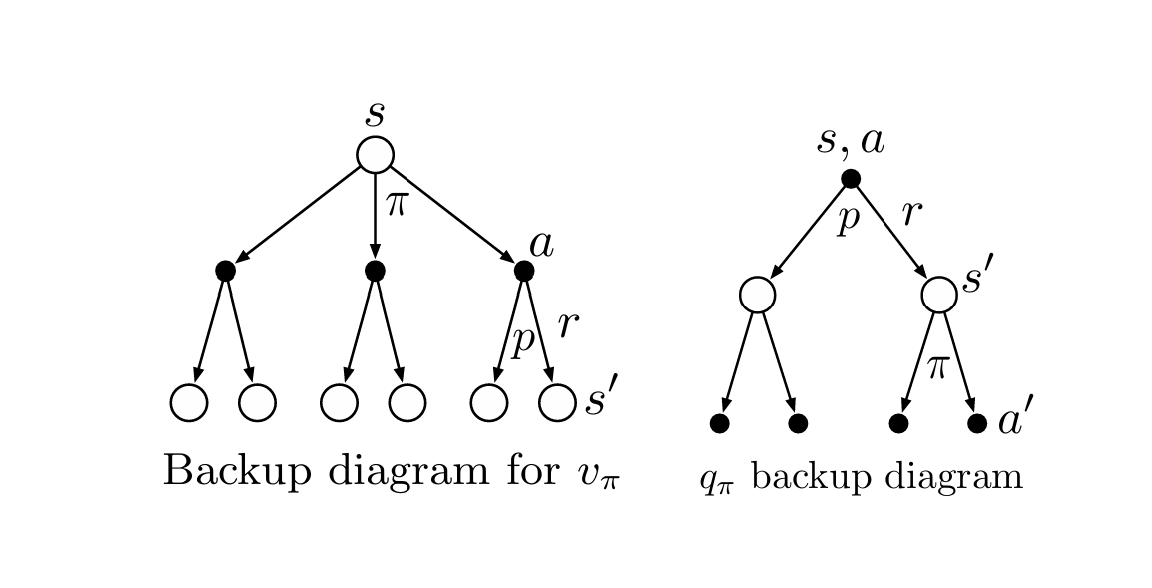
__Bellman Optimality Equation__
The Bellman Optimality Equation is used to find the optimal policy, which maximizes the cumulative reward:
$$V^*(s) = \max_{a} \sum_{s',r} P(s', r | s, a) \left[ r + \gamma V^*(s') \right]$$

$$Q^*(s, a) = \sum_{s',r} P(s', r | s, a) \left[ r + \gamma \max_{a'} Q^*(s', a') \right]$$

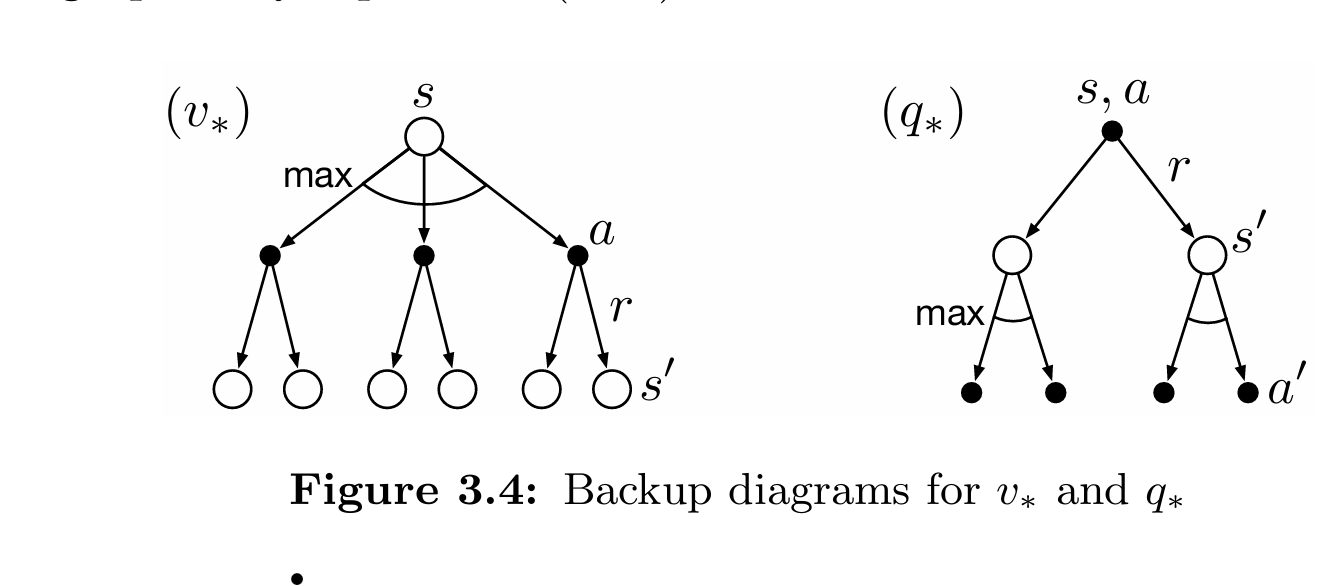(*Reference:Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). MIT Press, Cambridge, page 59-64*)



**Pseudo code for Bellman update function**<br>

**Algorithm**: Bellman_update<br>
**Input**: env (environment), policy ${\pi}$, state_function $V$, discount factor ${\gamma}$<br>
**Output**: Updated state value function $(V)$<br>

1. Define $nS$ as the number of states in the environment
2. Define $nA$ as the number of actions in the environment
3. Initialize $V$ as the given state_function

4. **For** each state $s$ in $nS$ **do**:<br>
      * **Set** new_$v$ ← $V[s]$         (Store current value of state $s$)<br>
      * **For** each action $a$ in policy $s$ **do**:<br>
          * Retrieve action probability action_proba ← policy$[s][a]$
          * **For** each transition (prob, next_state, reward, done) in env.$P[s][a]$ **do**:
              * Compute new value contribution:<br>
                 new_$v$ ← new_$v$ + $action$_$proba$ * $prob$ * ($reward$ + ${\gamma}$* $V$[next_state])
      * **Update** $V[s]$ ← new_$v$

5. **Return** updated $V$


# Task 1.2: Policy Evaluation [10 marks]

**Policy evaluation** is the process of estimating the value function for a given policy. It helps determine how good a policy is by computing the expected cumulative reward an agent will receive when following that policy.<br>
The value function $V(s)$ is updated iteratively using the Bellman equation until it converges (i.e., the values stop changing significantly).
$$V(s) = \sum_{a} \pi(s, a) \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma V(s') \right]$$

The below code define policy evaluation function and evaluates the given policy by calculating the value function $V(s)$ for all states until convergence.<br>

*Inputs of the policy evaluation function*<br>
- env → The environment (e.g., FrozenLake).
- agent → The agent following a policy.
- old_value → Initial estimates of $V(s)$.
- theta → A small threshold that determines when to stop iterating (convergence).




In [56]:
def policy_evaluation(env, agent, old_value, gamma=0.9, theta=1e-6):
    """
    Perform policy evaluation to estimate V(s) for a given policy using iterative updates.

    Parameters:
    - env: The environment object.
    - agent: The agent with a policy (π) to be evaluated.
    - old_value: The initial value function (V(s)) for all states.
    - gamma: The discount factor (default: 0.9).
    - theta: Convergence threshold (default: 1e-6).

    Returns:
    - V: The estimated value function for all states after policy evaluation.
    """

    # Initialize necessary variables
    V = old_value  # The initial value function
    delta = theta + 1  # To ensure the loop starts
    max_iter = 150  # Maximum number of iterations to prevent infinite loop

    # Iterative policy evaluation
    while delta > theta:  # Continue until convergence
        delta = 0  # Reset delta to track the maximum change for this iteration

        for s in range(env.observation_space.n):  # Loop over each state
            v = V[s]  # Store the current value of state s
            new_value = 0  # Initialize the new value for state s

            # Loop through all actions according to the policy for state s
            for a, action_prob in enumerate(agent.policy[s]):
                # For each transition (probability, next_state, reward, done) for action a
                for prob, next_state, reward, done in env.P[s][a]:
                    # Bellman update rule for V(s)
                    new_value += action_prob * prob * (reward + gamma * V[next_state])

            V[s] = new_value  # Update the value function for state s

            # Update delta to reflect the maximum change in value for any state
            delta = max(delta, abs(v - V[s]))

        # Decrease iteration count and break if exceeded max_iter
        max_iter -= 1
        if max_iter == 0:
            print("Maximum iterations reached.")
            break

    return V


# Task 1.3: Policy Improvement [10 marks]

Once the value function $V(s)$ has been computed, the next step is **policy improvement**. In this step, the current policy is modified to make it more optimal by choosing actions that maximize the expected cumulative reward based on the updated value function.<br>

This process typically involves selecting the best action for each state according to the value function and adjusting the policy accordingly.<br>
The policy improvement function greedily improves the policy by choosing the action that maximizes the expected reward, based on the current value function.
*Inputs of the policy improvement function*
- env → The environment (e.g., FrozenLake).
- agent → The agent following a policy.
- value_function: The value function $V(s)$<br>

The below policy_improvement function refines the current policy by:<br>
- Iterating over all states.
- Calculating the expected reward (Q-values) for each possible action using the current value function.
$$Q(s, a) = \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma V(s') \right]$$
- Updating the policy to select the best action for each state that maximizes the expected reward.

In [57]:
def policy_improvement(env, agent, value_function, gamma=0.9):
    """
    Perform policy improvement to update the agent's policy greedily based on the value function.

    Parameters:
    - env: The environment object.
    - agent: The agent with a policy to be improved.
    - value_function: The value function (V(s)) estimated for all states.
    - gamma: The discount factor (default: 0.9).

    Returns:
    - new_policy: The improved policy after applying the greedy policy improvement step.
    """
    current_policy = agent.policy  # Current policy (π) to be improved
    new_policy = np.zeros_like(current_policy)  # Initialize new_policy with zeros

    # Loop over all states to improve the policy
    for s in range(env.observation_space.n):  # For each state
        best_action = None  # Initialize best action

        # We will calculate Q(s, a) for each action and choose the best one
        best_value = -float('inf')  # Initialize best value as a very small number

        for a in range(env.action_space.n):  # For each possible action a
            action_value = 0  # Initialize Q(s, a)

            # Loop over all possible state transitions for the state-action pair (s, a)
            for prob, next_state, reward, done in env.P[s][a]:
                action_value += prob * (reward + gamma * value_function[next_state])

            # If this action has a higher Q-value, update the best action
            if action_value > best_value:
                best_value = action_value
                best_action = a

        # Set the new policy to be greedy with respect to the value function
        new_policy[s, best_action] = 1  # Assign probability 1 to the best action

    return new_policy


# Task 1.4: Policy Iteration Algorithm [15 marks]

The function executes **Policy Iteration**, which consists of alternating between:<br>
- Policy Evaluation: Estimating the value function for the current policy.
- Policy Improvement: Updating the policy by selecting the best actions based on the value function.<br>

It continues iterating until the policy becomes stable, meaning no further improvement is made, and then returns the optimal policy and value function along with timing information.

In [58]:
import time
import numpy as np

def policy_iteration(env, agent, value_function, MaxIter=200, theta=1e-6, gamma=0.9):
    """
    Perform Policy Iteration to find the optimal policy and value function.

    Parameters:
    - env: The environment.
    - agent: The agent object (with policy).
    - value_function: The initial value function (V(s)).
    - MaxIter: The maximum number of iterations.
    - theta: The convergence threshold for policy evaluation.
    - gamma: The discount factor (default: 0.9).

    Returns:
    - optimal_policy: The optimal policy after iteration.
    - optimal_value_function: The optimal value function for all states.
    """
    optimal_policy = agent.policy  # Initialize the policy (π)
    optimal_value_function = value_function  # Initialize value function

    start_time = time.time()  # Start time tracking

    num_iterations = 0  # Track the number of iterations

    for _ in range(MaxIter):
        num_iterations += 1
        delta = theta + 1

        # Policy Evaluation Step
        while delta > theta:
            delta = 0
            for s in range(env.observation_space.n):
                v = optimal_value_function[s]
                new_value = 0
                for a in range(env.action_space.n):
                    for prob, next_state, reward, done in env.P[s][a]:
                        new_value += optimal_policy[s, a] * prob * (reward + gamma * optimal_value_function[next_state])
                optimal_value_function[s] = new_value
                delta = max(delta, abs(v - optimal_value_function[s]))

        # Policy Improvement Step
        policy_stable = True
        for s in range(env.observation_space.n):
            old_action = np.argmax(optimal_policy[s])
            best_action = None
            best_value = -float('inf')

            for a in range(env.action_space.n):
                action_value = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    action_value += prob * (reward + gamma * optimal_value_function[next_state])

                if action_value > best_value:
                    best_value = action_value
                    best_action = a

            if old_action != best_action:
                policy_stable = False
                optimal_policy[s] = np.zeros(env.action_space.n)
                optimal_policy[s, best_action] = 1

        if policy_stable:
            break

    total_time = time.time() - start_time  # Compute total time
    avg_time_per_iteration = total_time / num_iterations

    print(f"Policy Iteration Completed in {num_iterations} iterations")
    print(f"Total Time Taken: {total_time:.6f} seconds")
    print(f"Average Time per Iteration: {avg_time_per_iteration:.6f} seconds")

    return optimal_policy, optimal_value_function



# Task 1.5: Value Iteration Algorithm [15 marks]
The **value_iteration** function performs:
- Value Update: For each state, it updates the value function by considering all possible actions and applying the Bellman update.
- Convergence: It iterates until the value function stops changing significantly (i.e., converges).
- Policy Extraction: Once the value function is optimal, it extracts the optimal policy by greedily choosing the best actions for each state.
- It returns the optimal policy and value function, along with iteration counts and timing information.

In [59]:
import time
import numpy as np

def value_iteration(env, agent, value_function, MaxIter=200, theta=1e-6, gamma=0.9):
    """
    Perform Value Iteration to find the optimal policy and value function.

    Parameters:
    - env: The environment.
    - agent: The agent object (with policy).
    - value_function: The initial value function (V(s)).
    - MaxIter: The maximum number of iterations.
    - theta: The convergence threshold for value iteration.
    - gamma: The discount factor (default: 0.9).

    Returns:
    - optimal_policy: The optimal policy after iteration.
    - optimal_value_function: The optimal value function for all states.
    """
    optimal_value_function = value_function  # Initialize value function
    optimal_policy = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize policy

    start_time = time.time()  # Start time tracking
    num_iterations = 0  # Track the number of iterations

    for _ in range(MaxIter):
        num_iterations += 1
        delta = 0  # Initialize delta to track convergence

        for s in range(env.observation_space.n):  # Loop over all states
            v = optimal_value_function[s]  # Store the old value of state s
            action_values = np.zeros(env.action_space.n)  # Initialize Q-values

            for a in range(env.action_space.n):
                action_value = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    action_value += prob * (reward + gamma * optimal_value_function[next_state])

                action_values[a] = action_value

            optimal_value_function[s] = np.max(action_values)  # Update V(s)
            delta = max(delta, abs(v - optimal_value_function[s]))  # Track largest change

        if delta < theta:  # Check for convergence
            break

    # Policy Extraction
    for s in range(env.observation_space.n):
        action_values = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            action_value = 0
            for prob, next_state, reward, done in env.P[s][a]:
                action_value += prob * (reward + gamma * optimal_value_function[next_state])

            action_values[a] = action_value

        best_action = np.argmax(action_values)  # Best action
        optimal_policy[s] = np.zeros(env.action_space.n)
        optimal_policy[s, best_action] = 1

    total_time = time.time() - start_time  # Compute total time
    avg_time_per_iteration = total_time / num_iterations

    print(f"Value Iteration Completed in {num_iterations} iterations")
    print(f"Total Time Taken: {total_time:.6f} seconds")
    print(f"Average Time per Iteration: {avg_time_per_iteration:.6f} seconds")

    return optimal_policy, optimal_value_function


# Task 1.6 Testing FrozenLake_5x5_bridge

Now that you have created the functions is time to test them on the environment.

**Your task is to try different values of GAMMA and compare both Value Iteration and Policy Iteration on it**

Write as many comments as you consider necessary, include some plots (for example use the function `plot_values` to display the state and action value functions)

The **Gamma** $(γ)$ parameter, often referred to as the discount factor, is a key component in value iteration and policy iteration. It determines the importance of future rewards relative to immediate rewards.
- A small $γ$ means the agent cares more about immediate rewards.
- A large $γ$ means the agent is more focused on the future.
to explore how the agent's behavior changes with respect to different levels i experimented $3$ different values of gamma $(0.2,0.5,0.9)$<br>

Policy Iteration converges in fewer iterations compared to Value Iteration in all cases.Value Iteration takes more iterations to converge but each iteration is faster.<br>

Policy Iteration takes more time per iteration due to its policy evaluation step but converges faster in terms of the number of iterations.
Value Iteration has a lower per-iteration time since it updates the value function directly but requires more iterations.<br>

Lower $γ$ values $(0.2)$ lead to faster convergence and Higher $γ$ values $(0.9)$ take longer.<br>

**FrozenLake_15$×$9** takes longer than **FrozenLake_5$×$5** because it has more states, leading to more computations.Larger environments increase both iteration count and total time due to more states to evaluate.

The results are summerized as follows<br>
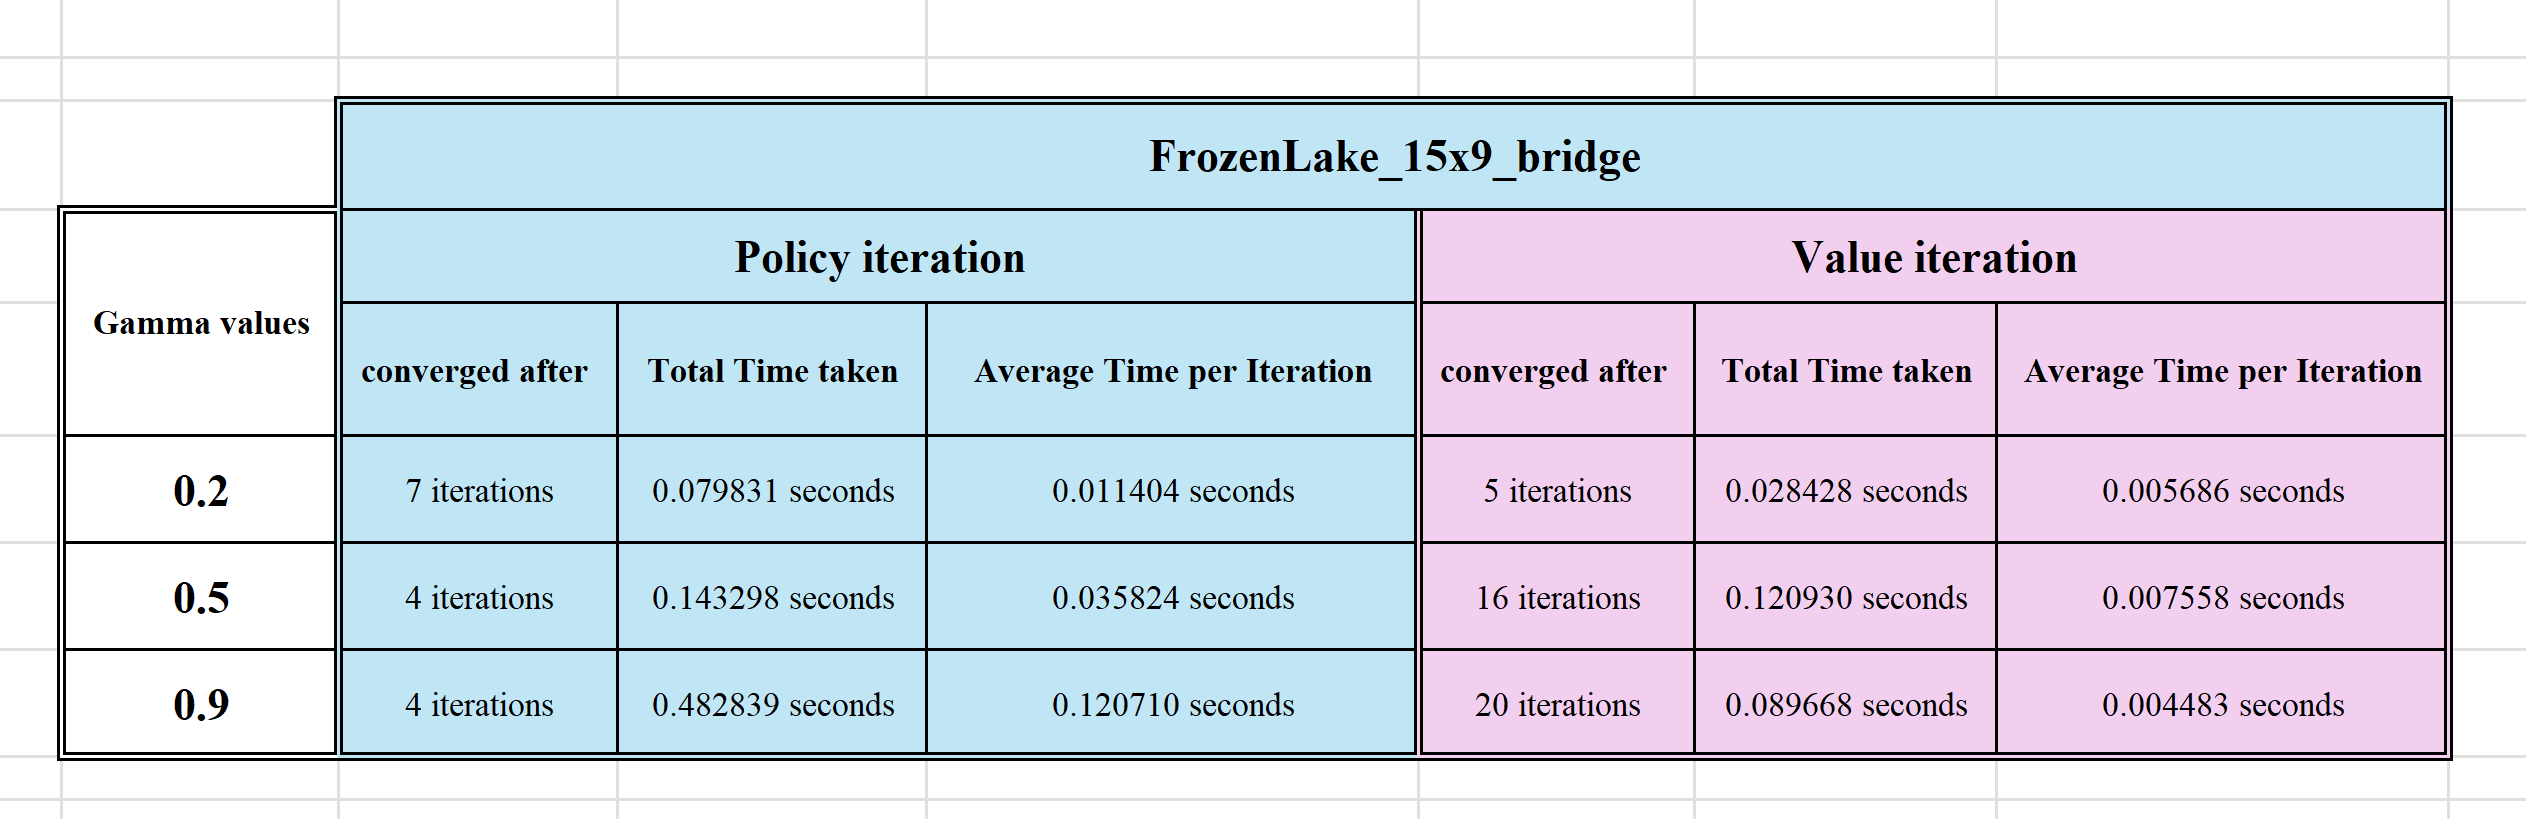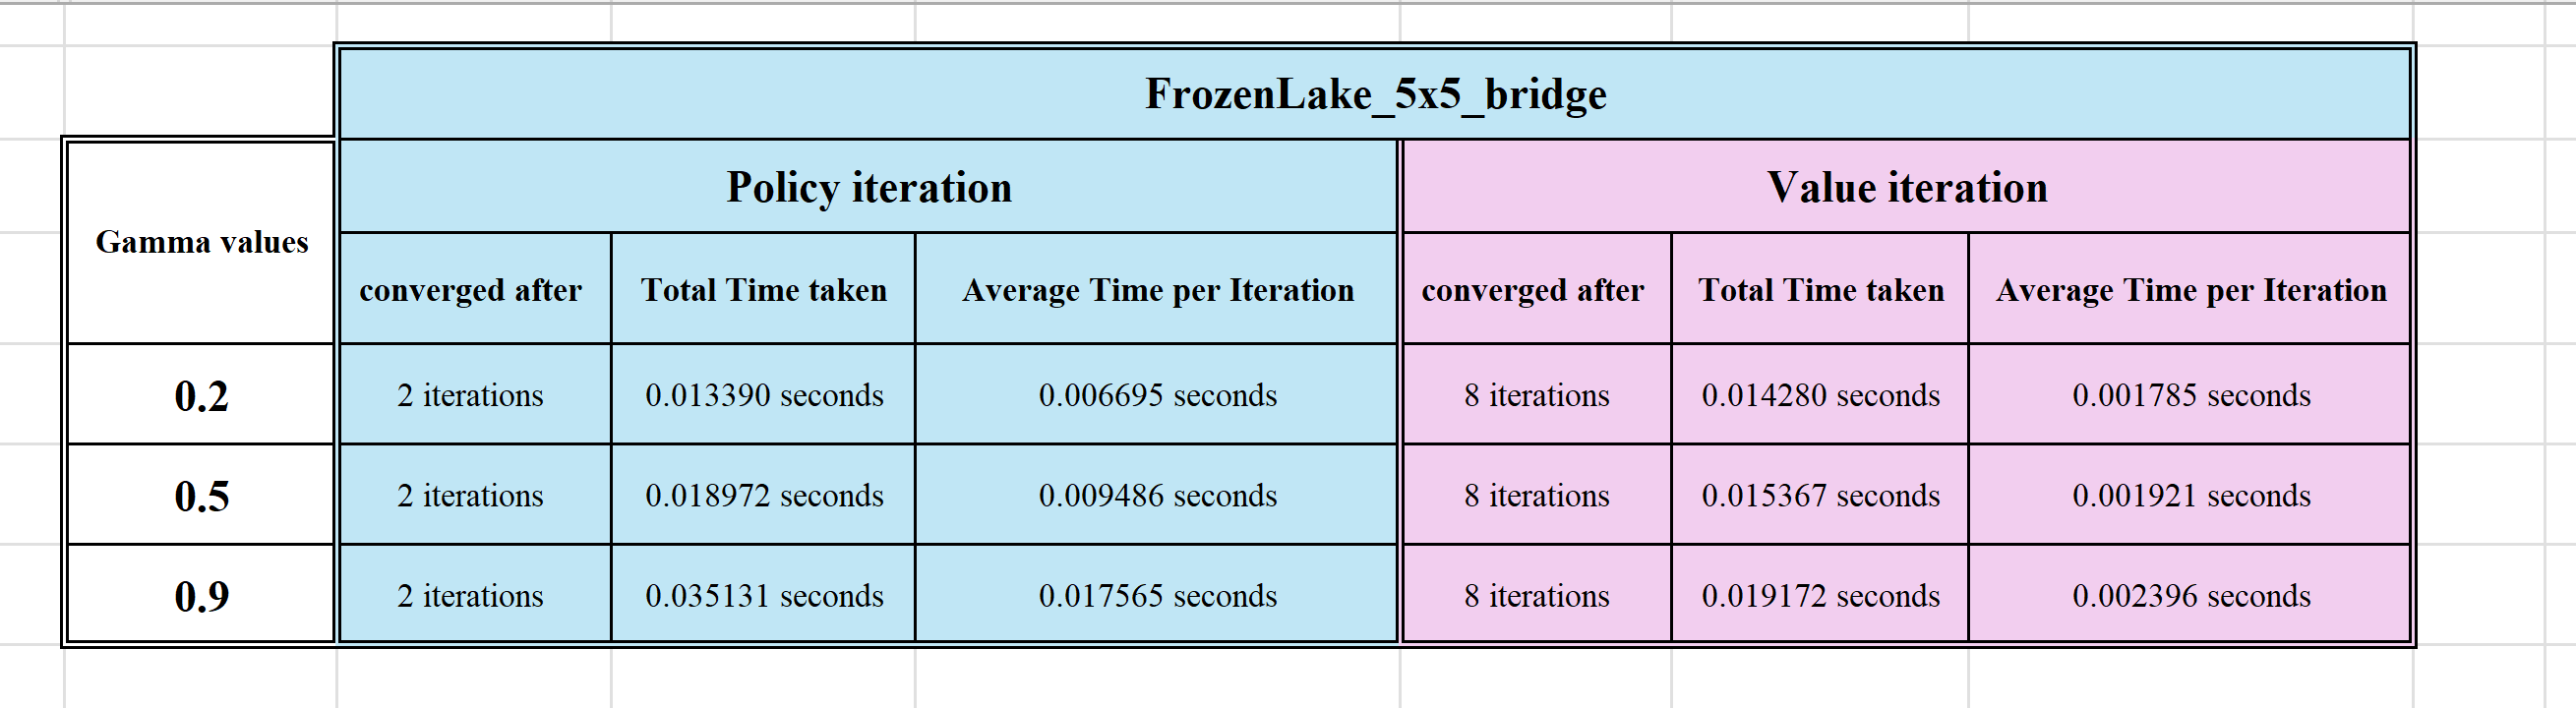

**Plot for FrozenLake_5x5_bridge**<br>
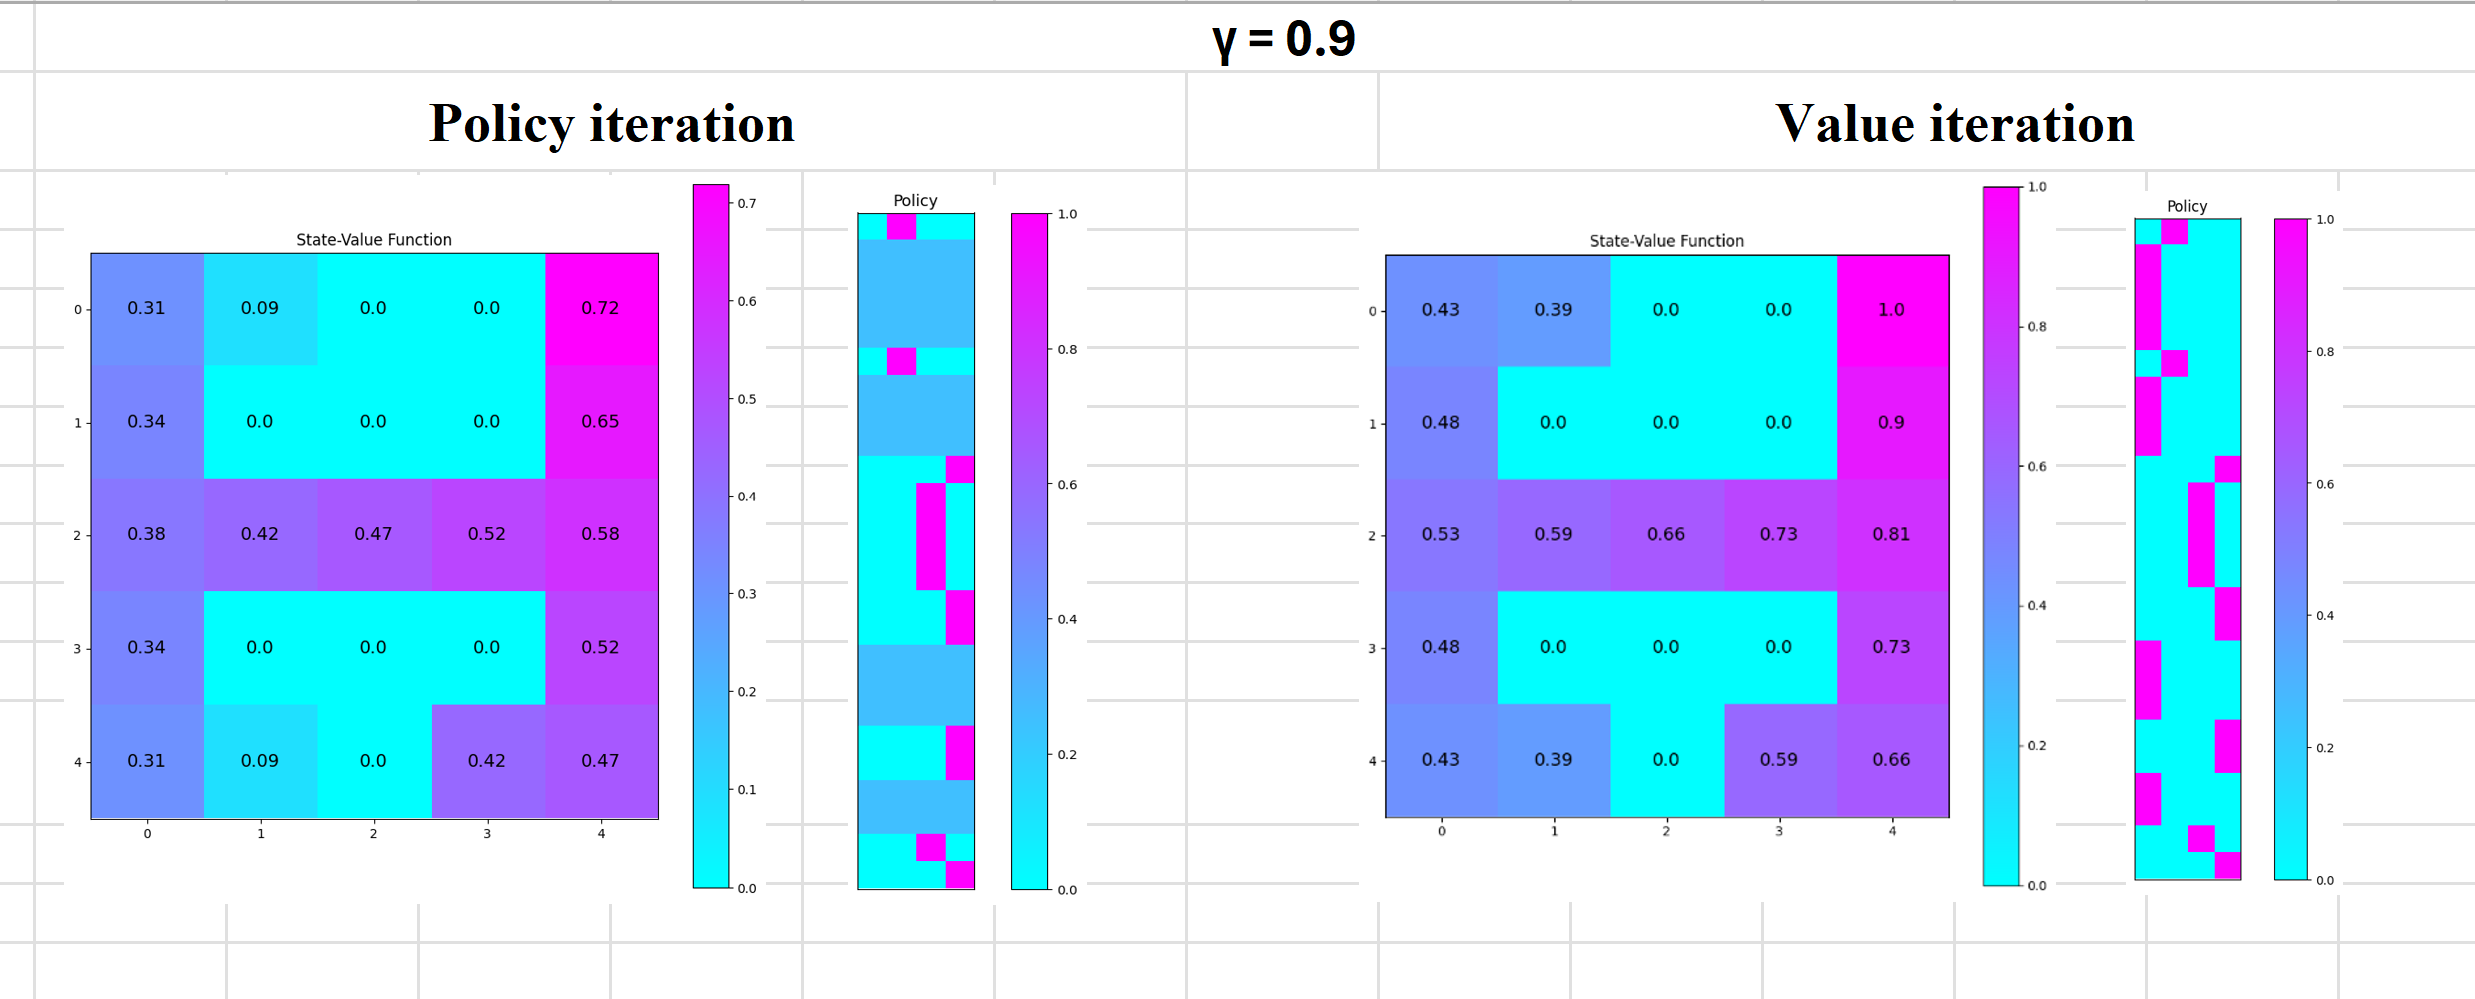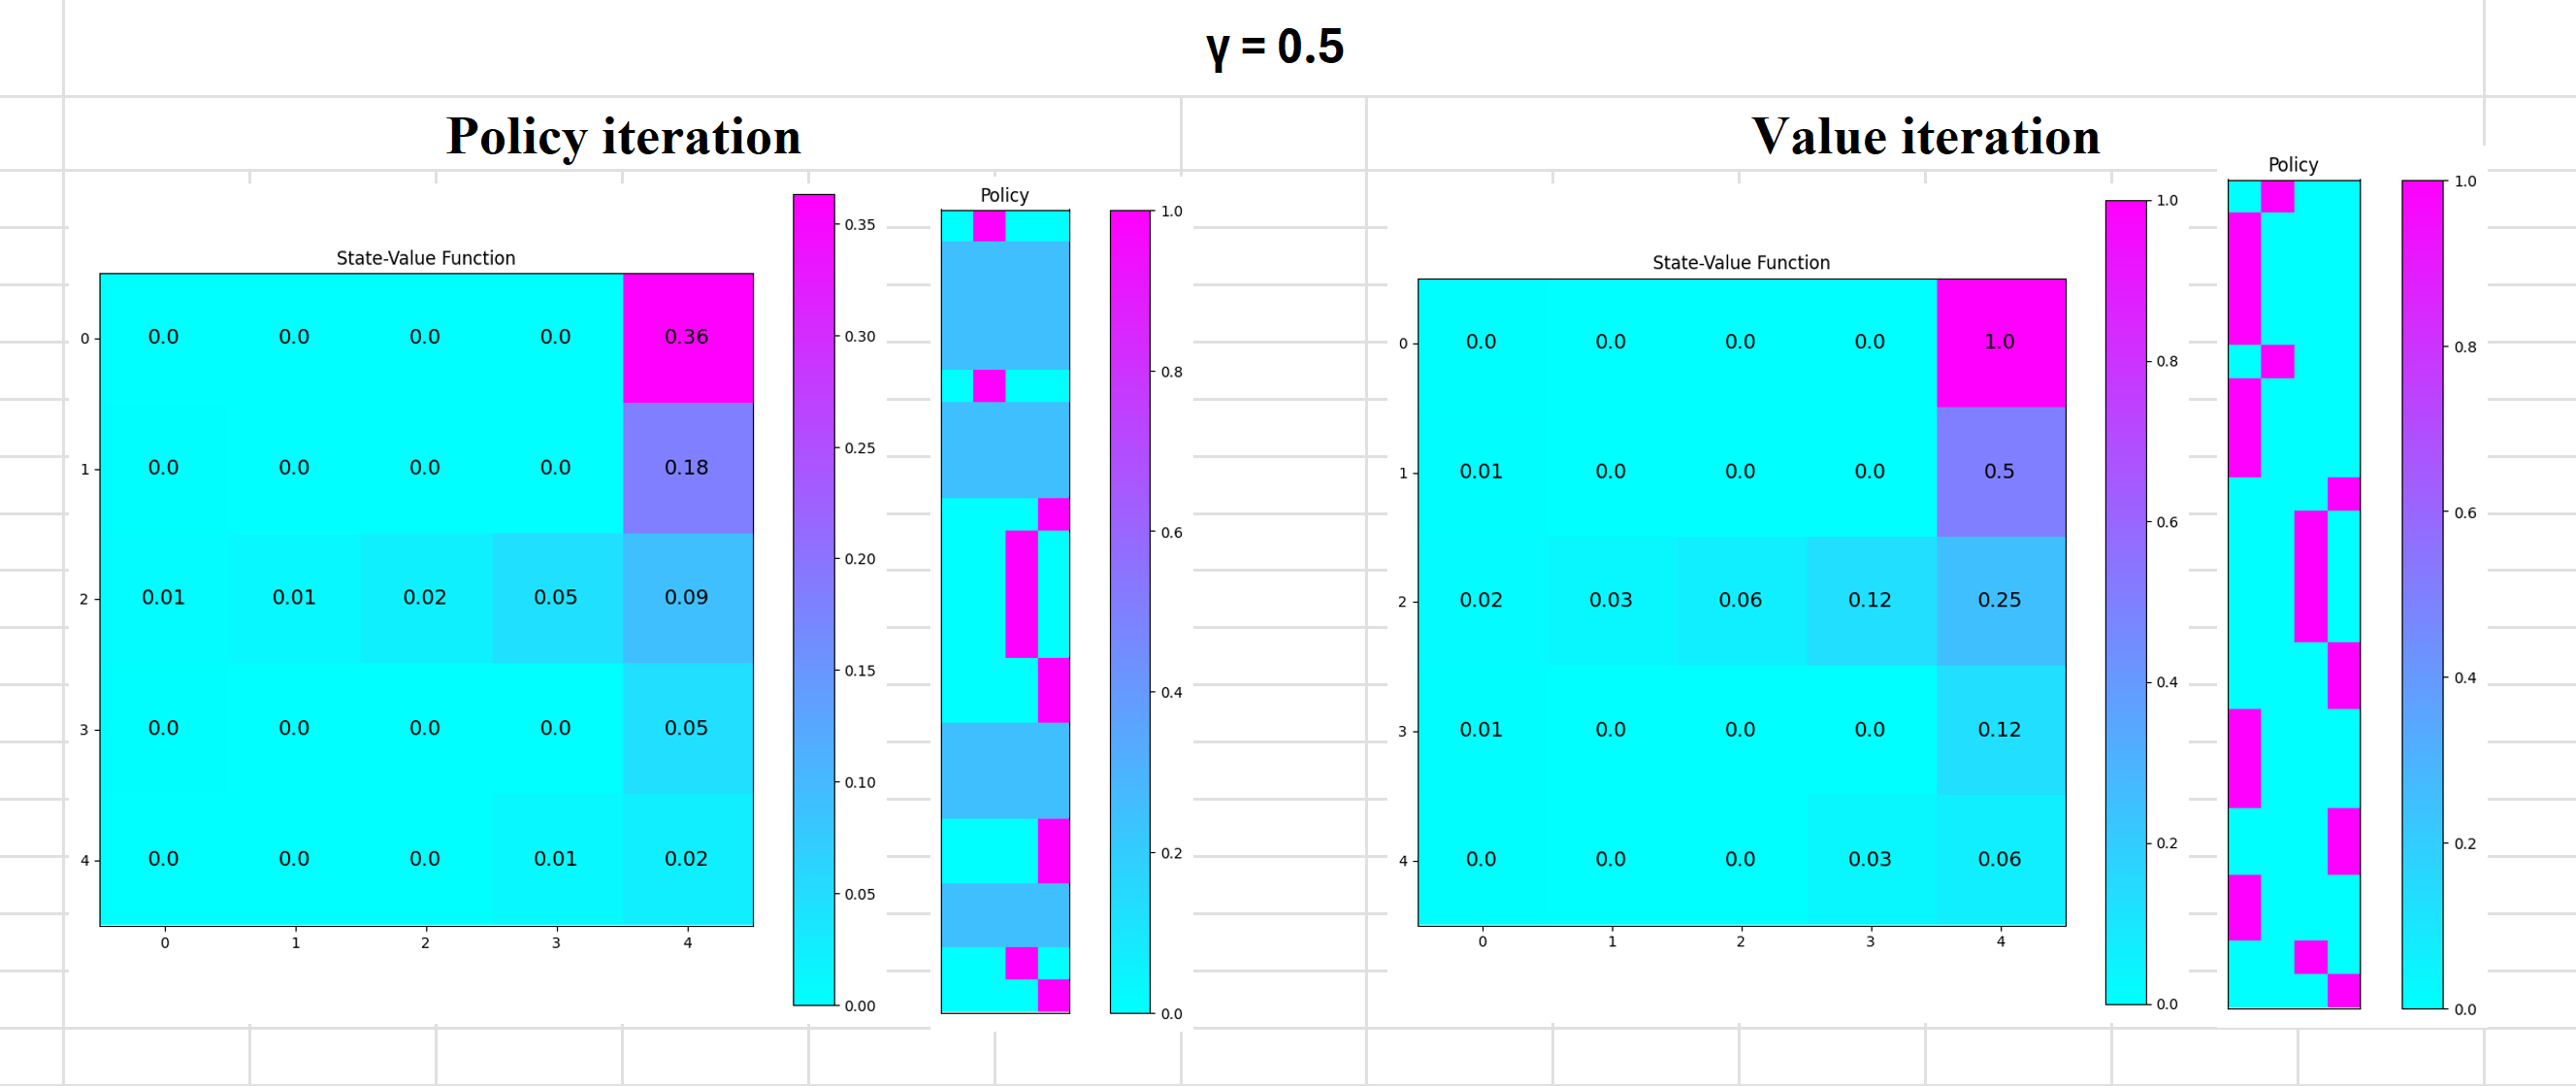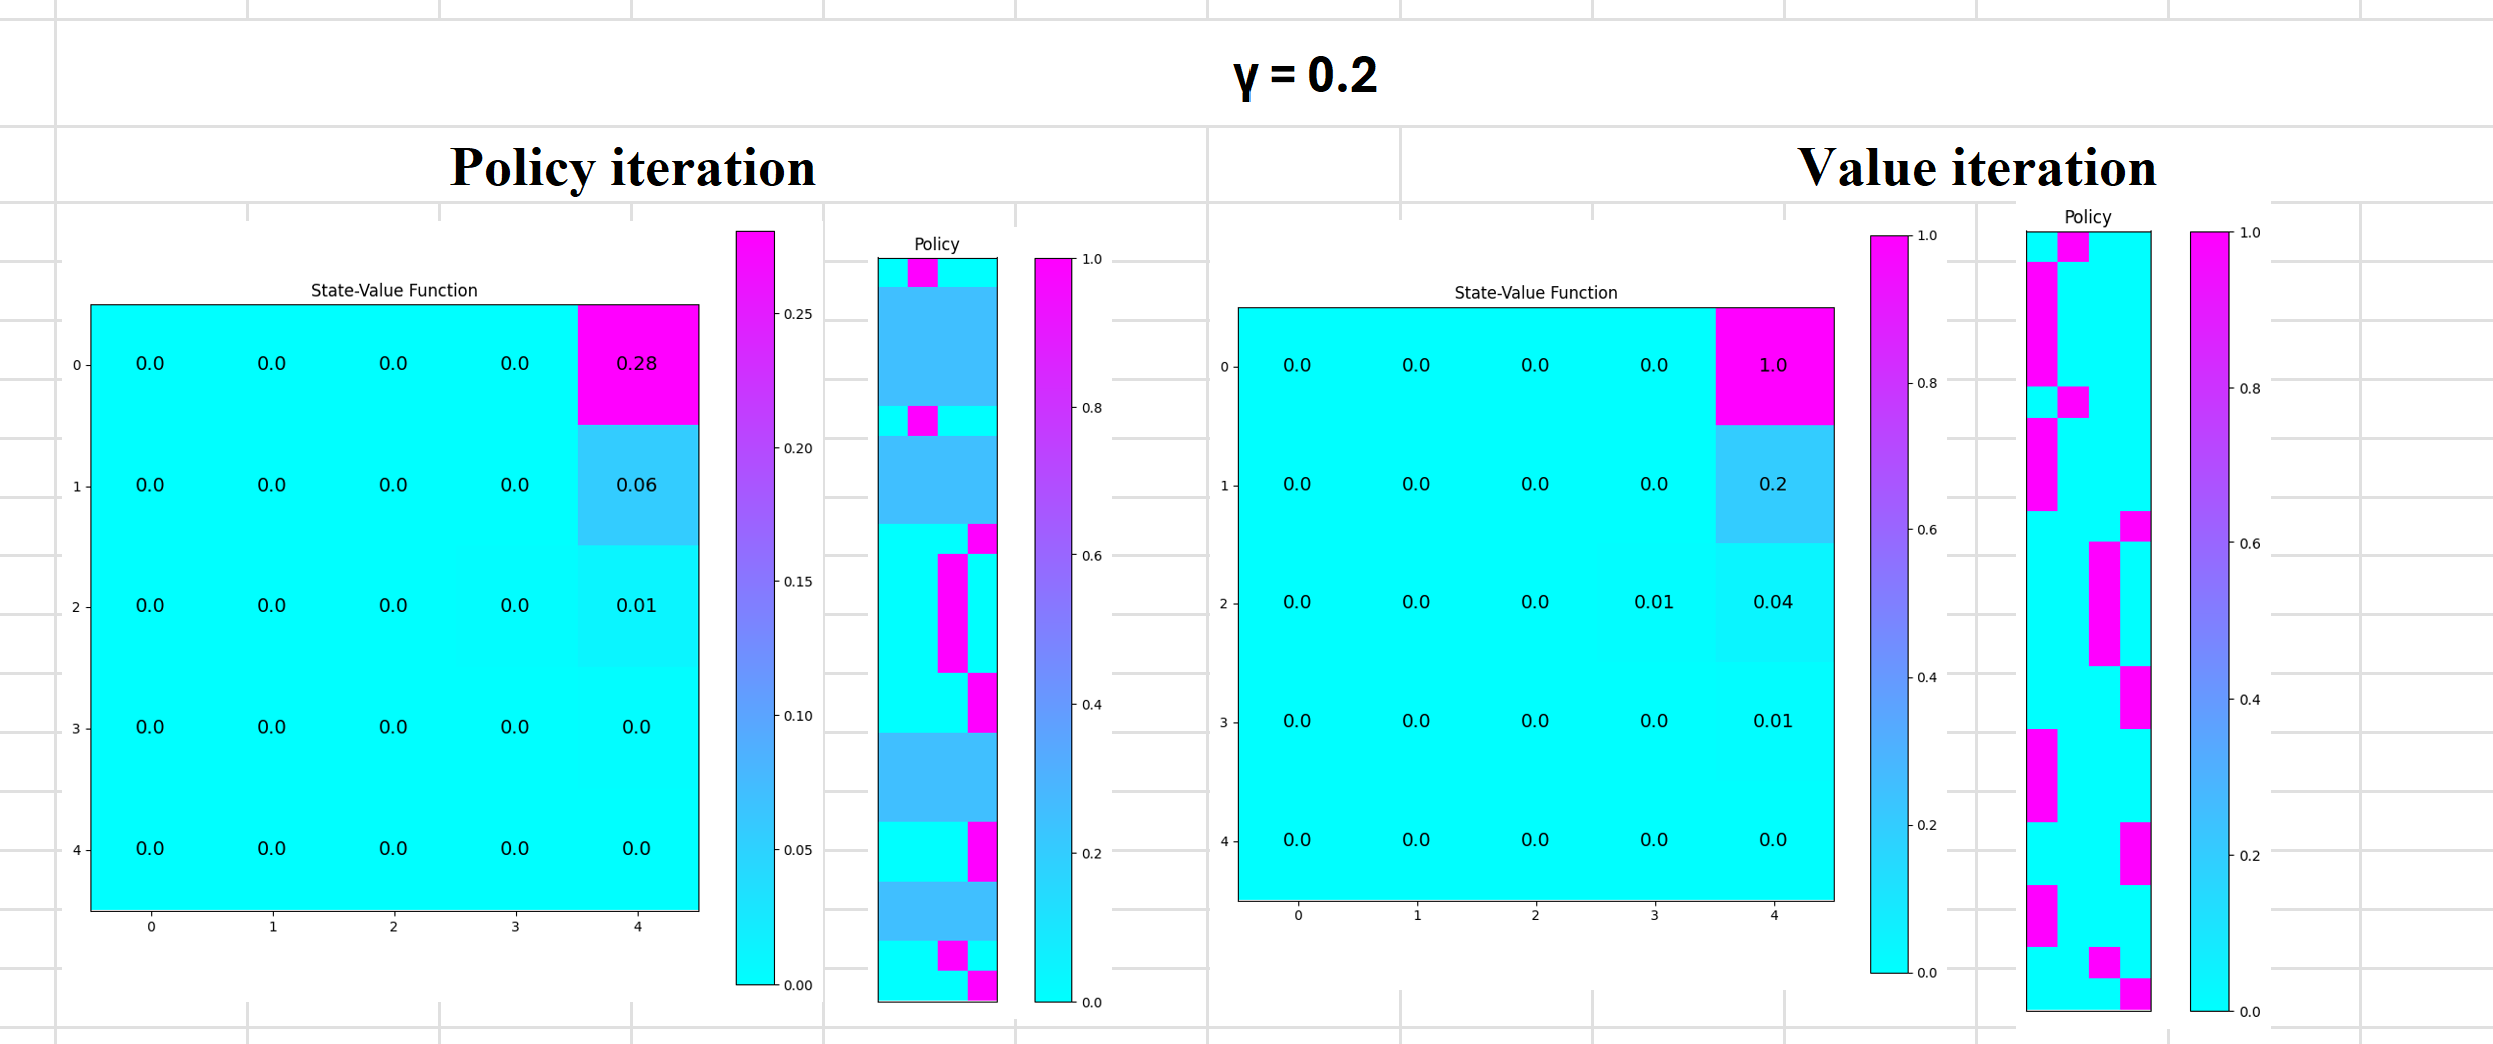
**Plot for FrozenLake_15x9_bridge**<br>
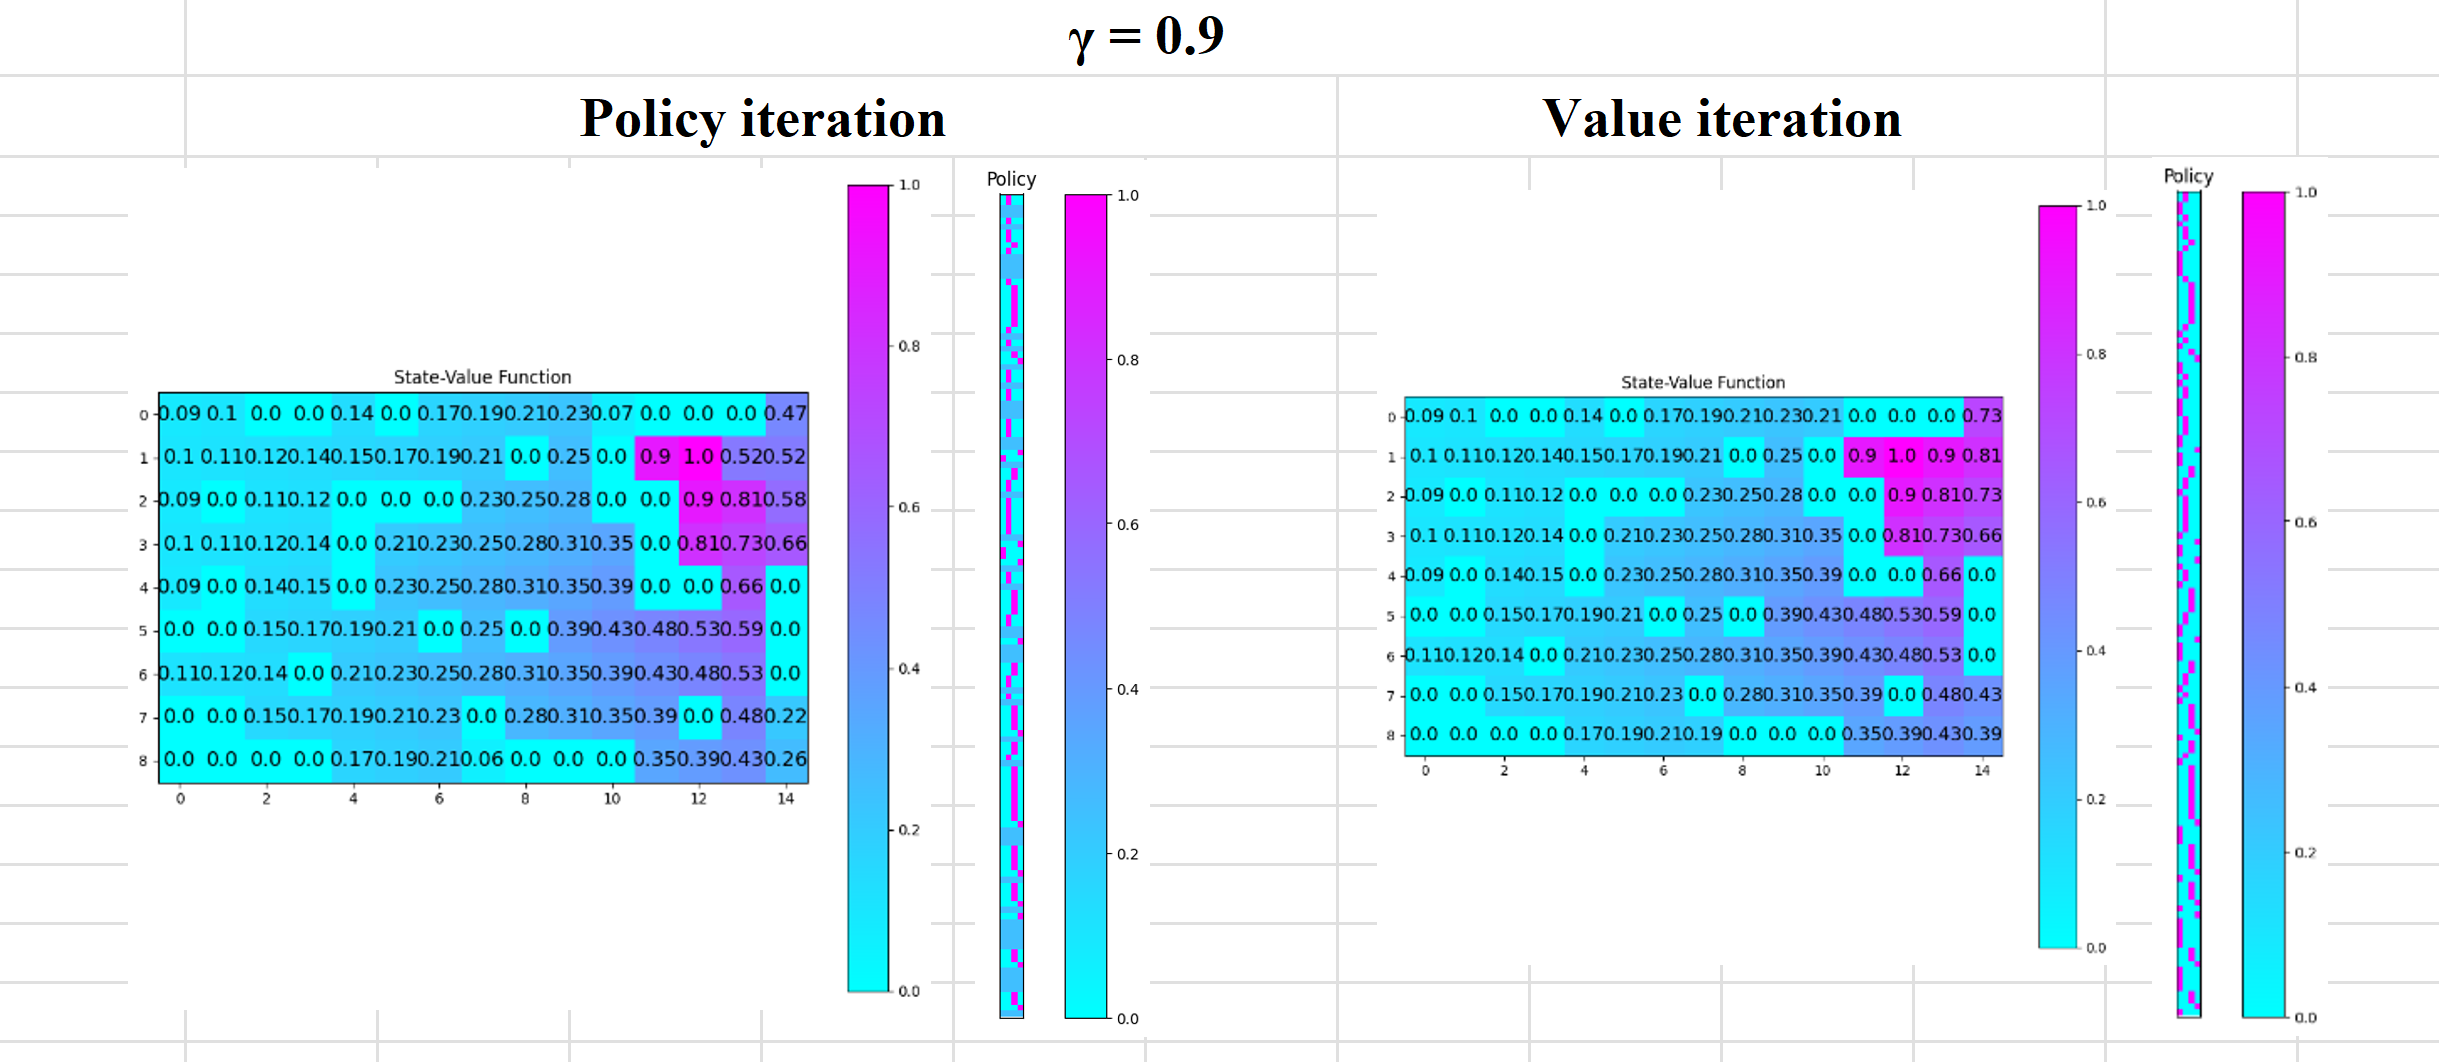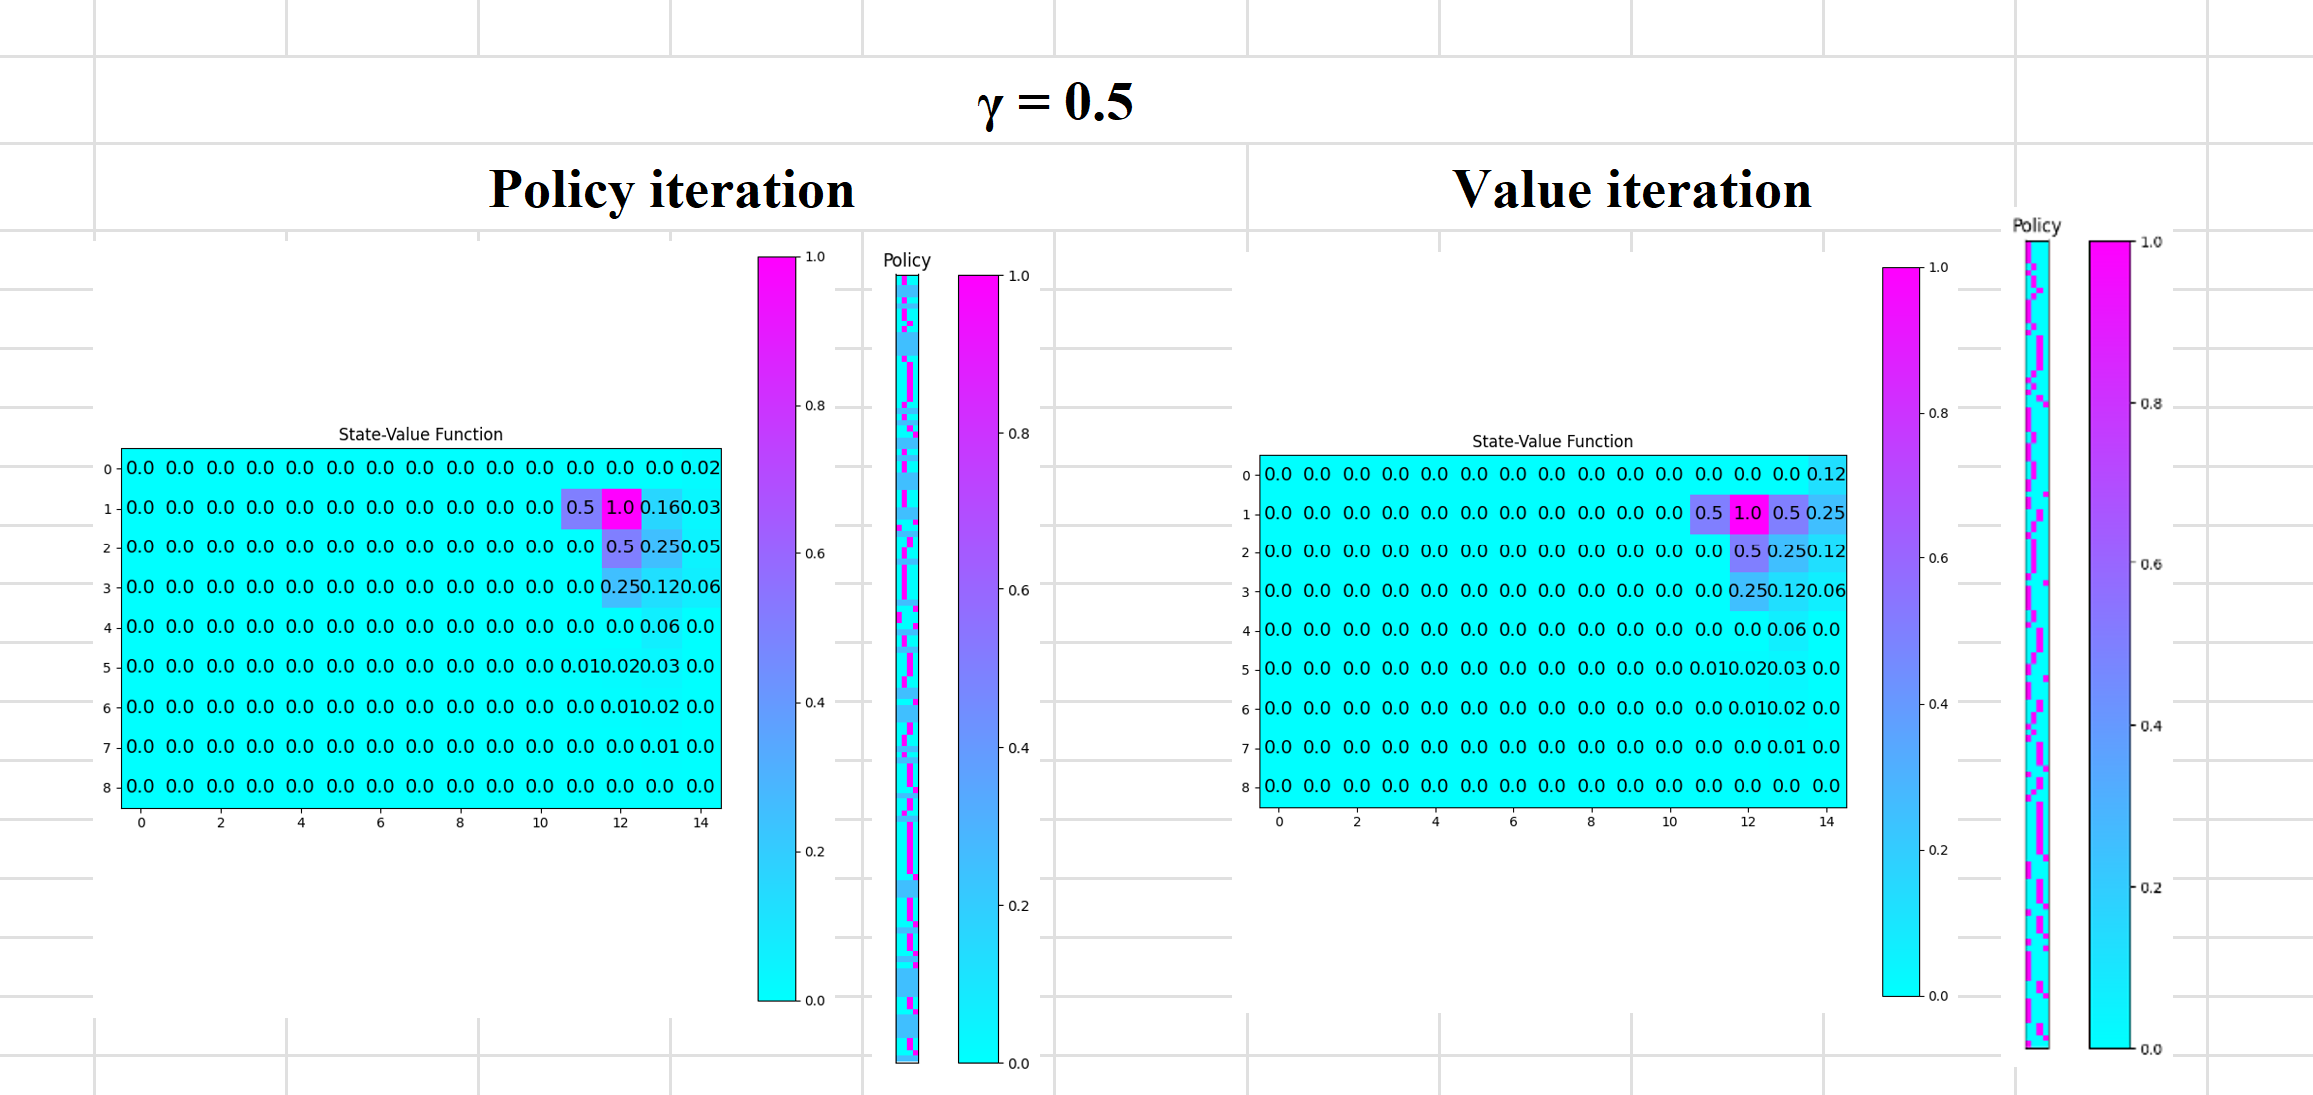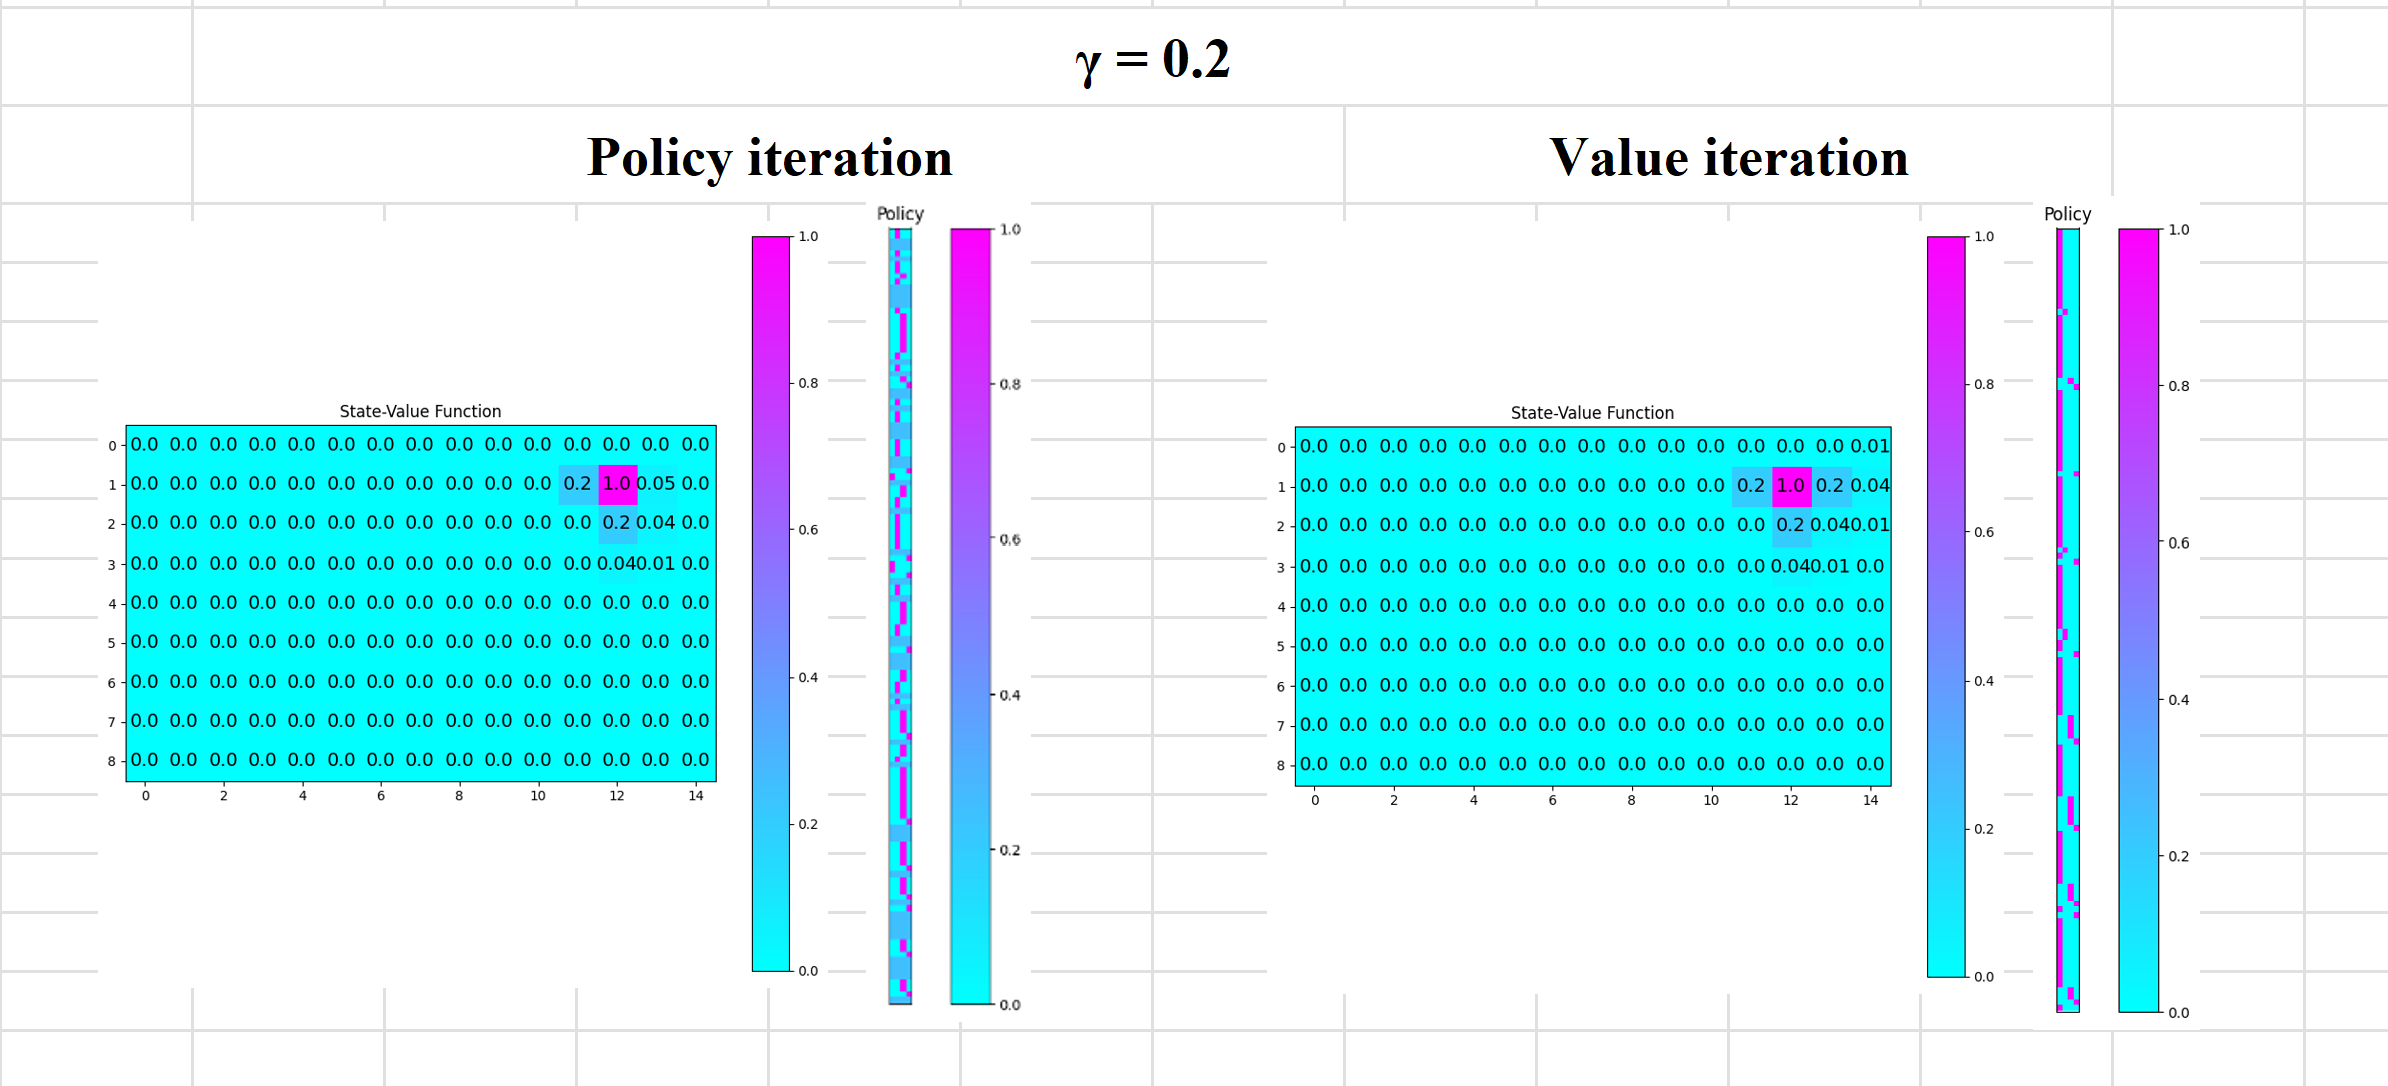

In [60]:
# Load environment
env_bridge = wrap_env(gym.make('FrozenLake-v1', desc=FL_5x5_bridge, is_slippery=False))
state = env_bridge.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_bridge.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env_bridge.action_space)

Initial state: 0
State space: Discrete(25)
Action space: Discrete(4)


**Policy Iteration**<br>
agent_bridge_1

In [61]:
nS_bridge = env_bridge.observation_space.n
nA_bridge = env_bridge.action_space.n
agent_bridge_1 = RandomAgent(env_bridge) #an instantiation of an agent of the class RandomAgent

In [62]:
value_function_0 = np.zeros(nS_bridge)
optimal_policy, optimal_value_function = policy_iteration(env_bridge, agent_bridge_1, value_function_0, MaxIter=1000, theta=1e-6)

Policy Iteration Completed in 2 iterations
Total Time Taken: 0.029460 seconds
Average Time per Iteration: 0.014730 seconds


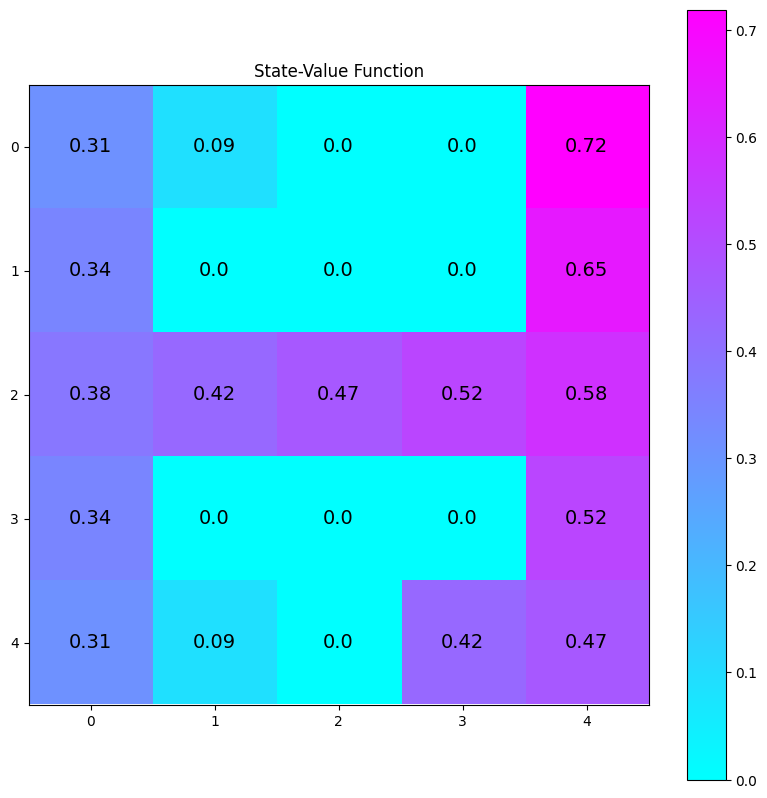

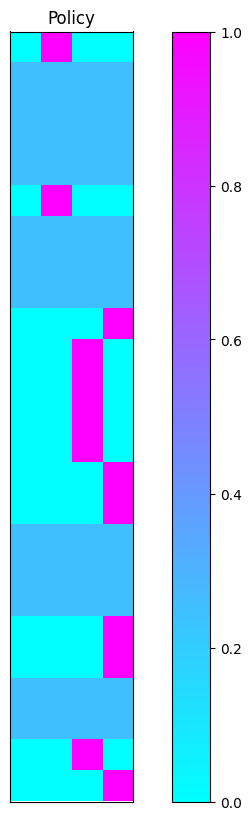

In [63]:
plot_values(optimal_value_function, dimensions=(5,5), name='State')
plot_values(optimal_policy, dimensions=(nS_bridge, nA_bridge), name = 'Policy')

In [64]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env_bridge, agent_bridge_1)

Total reward: 1.0


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


**Value iteration**<br>
agent_bridge_2

In [65]:

agent_bridge_2 = RandomAgent(env_bridge)

In [66]:
value_function_0 = np.zeros(nS_bridge)
optimal_policy_2, optimal_value_function_2 = value_iteration(env_bridge, agent_bridge_2, value_function_0, MaxIter=1000, theta=1e-6)

Value Iteration Completed in 8 iterations
Total Time Taken: 0.006753 seconds
Average Time per Iteration: 0.000844 seconds


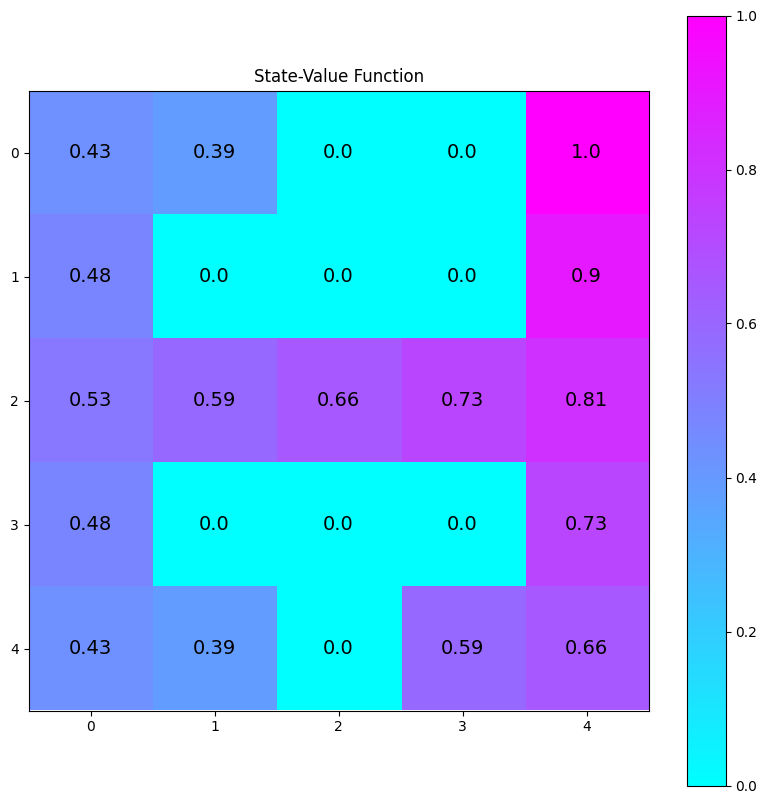

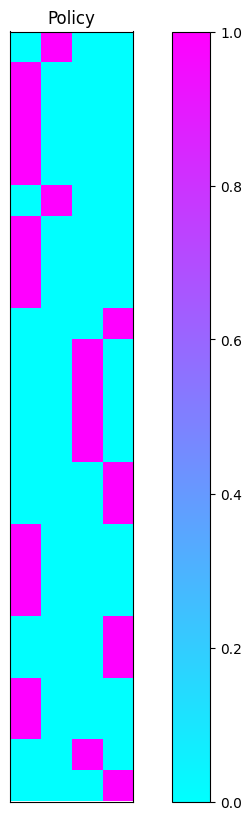

In [67]:
plot_values(optimal_value_function_2, dimensions=(5,5), name='State')
plot_values(optimal_policy_2, dimensions=(nS_bridge, nA_bridge), name = 'Policy')

In [68]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env_bridge, agent_bridge_2)

Total reward: 0.0


**Question** Can you measure which method find the optimal policy faster? (if any) **[extra 10 marks]**<br>

To measure which method finds the optimal policy faster, we need to look at the following:

- **Number of Iterations**: The number of iterations each algorithm takes to converge to the optimal policy.<br>
- **Time per Iteration**: The amount of time taken for each iteration of the algorithm.
- **Total Time**: This is the total time taken by the algorithm to converge.<br>

Based on the above outputs  for Policy Iteration and Value Iteration eg. for gamma ($0.9$)<br>

**FrozenLake_5$x$5_bridge**<br>

__Policy Iteration:__
- Number of Iterations: **2** iteration
- Total Time: **0.035131** seconds
- Average Time per Iteration: **0.017565** seconds<br>

__Value Iteration:__
- Number of Iterations: **8** iterations
- Total Time: **0.019172** seconds
- Average Time per Iteration: **0.002396** seconds<br>

**FrozenLake_15$x$9_bridge**<br>

__Policy Iteration:__
- Number of Iterations: **4** iteration
- Total Time: **0.482839** seconds
- Average Time per Iteration: **0.120710** seconds<br>

__Value Iteration:__
- Number of Iterations: **20** iterations
- Total Time: **0.089668** seconds
- Average Time per Iteration: **0.004483** seconds<br>

For small environments (5$×$5), Policy Iteration is more efficient as it converges in just $2$ iterations.For large environments (15$×$9), Policy Iteration becomes slower as its evaluation step grows more expensive.Value Iteration is preferable in large state spaces since each iteration is computationally cheaper.**Value Iteration took more iterations However,each iteration was quicker**.<br>

**Policy Iteration** is typically faster when the environment is small or when there are fewer state-action pairs to evaluate, as it stabilizes the policy quickly with fewer iterations.<br>
**Value Iteration** is more computationally intensive per iteration because it updates the value function for all states in every iteration, but it usually takes more iterations to converge.

In conclusion,<br>
The choice between these methods depends on the complexity of the environment. In large or complex state spaces, Value Iteration may be the better option due to its lower per-iteration cost, whereas Policy Iteration can be advantageous when the state space is small.

# Larger Frozen Lake environment

In [69]:
FL_15x9=["FFHHFHFFFFFHGHF","FFFFFFFFHFHFFFF","FHFFHHHFFFHHFFF","FFFFHFFFFFFHFFF","FHFFHFFSFFFHHFH","HHFFFFHFHFFFFFH","FFFHFFFFFFFFFFH","HHFFFFFHFFFFHFF","FFHHFFFFHHHFFFF"]

In [70]:
# Load environment
env_large_FL = wrap_env(gym.make('FrozenLake-v1', desc=FL_15x9,is_slippery=False))
state = env_large_FL.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_large_FL.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env_large_FL.action_space)

Initial state: 67
State space: Discrete(135)
Action space: Discrete(4)


In [71]:
agent_large_FL = RandomAgent(env_large_FL)

# Task 1.7 Testing Frozen Lake Large Environment [20 marks]

**Policy Iteration**<br>
agent_Large_FL_2

In [72]:
state = env_large_FL.reset()
iterations = 0
max_iter = 100
total_reward = 0
while not done:

    env_large_FL.render()
    iterations += 1
    #your agent goes here
    action = env_large_FL.action_space.sample()
    # action_space.sample() selects at random one action from the action space: {0,1,2,3}
    next_state, reward, done, info = env_large_FL.step(action)
    total_reward += reward


    if iterations > max_iter:
      done = True

print("Total reward:", total_reward)
env_large_FL.close()
show_video()

Total reward: 0


In [73]:
# Load environment
env_large = wrap_env(gym.make('FrozenLake-v1', desc=FL_15x9,is_slippery=False))
state = env_large.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_large.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env_large.action_space)

Initial state: 67
State space: Discrete(135)
Action space: Discrete(4)


In [74]:
nS_bridg = env_large.observation_space.n
nA_bridg = env_large.action_space.n
agent_large_1 = RandomAgent(env_large)

In [75]:
value_function = np.zeros(nS_bridg)
optimal_policy_l, optimal_value_function_l = policy_iteration(env_large, agent_large_1, value_function, MaxIter=1000, theta=1e-6)

Policy Iteration Completed in 4 iterations
Total Time Taken: 0.299360 seconds
Average Time per Iteration: 0.074840 seconds


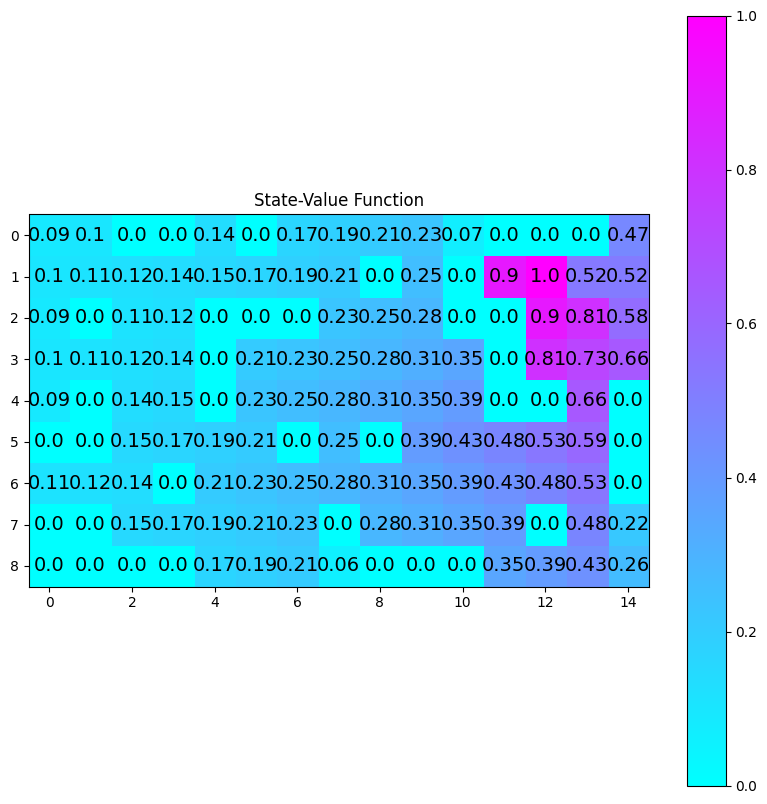

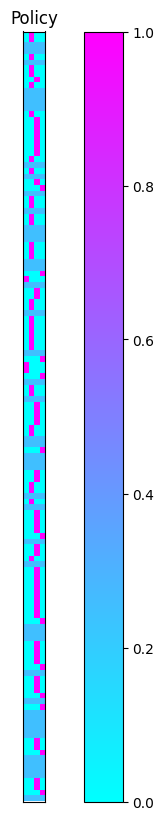

In [76]:
plot_values(optimal_value_function_l, dimensions=(9,15), name='State')
plot_values(optimal_policy_l, dimensions=(nS_bridg, nA_bridg), name = 'Policy')

In [77]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((1400, 900)) # change to the real resolution
run_agent(env_large, agent_large_1)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total reward: 1.0


**Value iteration**<br>
agent_large_2

In [78]:

agent_large_2 = RandomAgent(env_large)


In [79]:
value_function = np.zeros(nS_bridg)
optimal_policy_2, optimal_value_function_2 = value_iteration(env_large, agent_large_2, value_function, MaxIter=1000, theta=1e-6)

Value Iteration Completed in 20 iterations
Total Time Taken: 0.068612 seconds
Average Time per Iteration: 0.003431 seconds


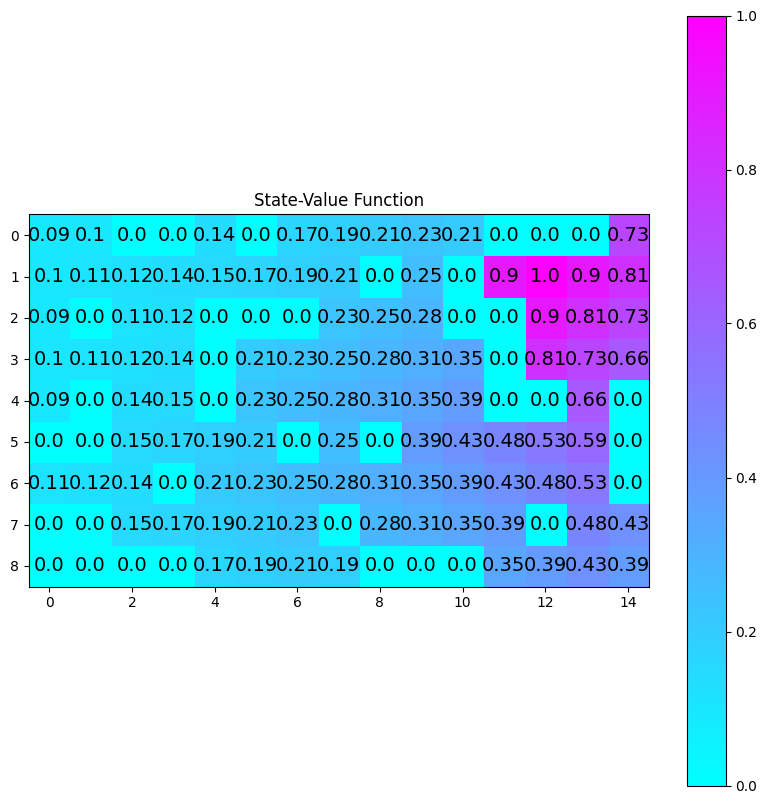

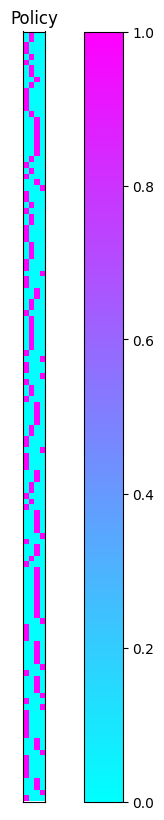

In [80]:
plot_values(optimal_value_function_2, dimensions=(9,15), name='State')
plot_values(optimal_policy_2, dimensions=(nS_bridg, nA_bridg), name = 'Policy')

In [81]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((1400, 900)) # change to the real resolution
run_agent(env_large, agent_large_2)

Total reward: 0.0
